In [228]:
import tensorflow as tf
tf.test.is_gpu_available()

True

In [229]:
import os
os.chdir('D:/drive/train')

In [248]:


import numpy as np
import tensorflow
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
import h5py
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from sklearn.metrics import confusion_matrix
import itertools
#import random
#import shutil
#for broken data stream error
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import matplotlib.pyplot as plt
%matplotlib inline

In [249]:
test_path = "D:/drive/test"

In [279]:
test_batches = ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input).flow_from_directory(
    test_path, target_size=(224,224), batch_size=50, shuffle=False)

Found 11803 images belonging to 2 classes.


In [251]:
train_path = "D:/drive/train"

In [280]:
train_batches = ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input).flow_from_directory(
    train_path, target_size=(224,224), batch_size=200)

Found 38659 images belonging to 2 classes.


In [253]:
valid_path = "D:/drive/valid"

In [281]:
valid_batches = ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input).flow_from_directory(
    valid_path, target_size=(224,224), batch_size=50)

Found 9666 images belonging to 2 classes.


In [282]:
mobile = tf.keras.applications.mobilenet.MobileNet()


mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

                                                                 
 conv_pw_8_bn (BatchNormaliz  (None, 14, 14, 512)      2048      
 ation)                                                          
                                                                 
 conv_pw_8_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_dw_9 (DepthwiseConv2D)  (None, 14, 14, 512)      4608      
                                                                 
 conv_dw_9_bn (BatchNormaliz  (None, 14, 14, 512)      2048      
 ation)                                                          
                                                                 
 conv_dw_9_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_pw_9 (Conv2D)          (None, 14, 14, 512)       262144    
                                                                 
 conv_pw_9

In [283]:
#Deleting the last 5 layers and replacing it with a dense softmax layer consisting of 2 nodes: Fire and Non-fire
x = mobile.layers[-2].output
predictions = Dense(2, activation='softmax')(x)
model = Model(inputs=mobile.input, outputs=predictions)

In [241]:
#for layer in model.layers[:-23]:
    #layer.trainable = False

In [284]:
model.summary()

Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                   

                                                                 
 conv_pw_8_bn (BatchNormaliz  (None, 14, 14, 512)      2048      
 ation)                                                          
                                                                 
 conv_pw_8_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_dw_9 (DepthwiseConv2D)  (None, 14, 14, 512)      4608      
                                                                 
 conv_dw_9_bn (BatchNormaliz  (None, 14, 14, 512)      2048      
 ation)                                                          
                                                                 
 conv_dw_9_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_pw_9 (Conv2D)          (None, 14, 14, 512)       262144    
                                                                 
 conv_pw_9

In [285]:
#Freezing weights all the layers upto the 4th last layer
#This is done because we will retrain only the last three layers
for layer in model.layers[:-4]:
    layer.trainable = False

In [286]:
model.compile(Adam(learning_rate=.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [183]:
#training_datagenarator= ImageDataGenerator(rescale=1./255,horizontal_flip=True,
    #vertical_flip=True,shear_range=0.2,
    #zoom_range=0.2,width_shift_range=0.2,
    #height_shift_range=0.2,validation_split=0.1)

In [184]:
#train=training_datagenarator.flow_from_directory('D:/drive/train',
                                                #target_size=(224, 224),
                                       #class_mode='categorical', batch_size=64 )

In [287]:
checkpoint=tf.keras.callbacks.ModelCheckpoint("D:/drive/train.h5",
                                             monitor='val_loss',mode="min",
                                             save_best_only=True)

In [288]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, min_lr=0.000001)

In [289]:
model.fit_generator(train_batches, steps_per_epoch = 34, validation_data=valid_batches, validation_steps=34, epochs=1, verbose=1, callbacks=[checkpoint,reduce_lr])

C:\Users\mamoo\AppData\Local\Temp\ipykernel_12952\1882275340.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_batches, steps_per_epoch = 34, validation_data=valid_batches, validation_steps=34, epochs=1, verbose=1, callbacks=[checkpoint,reduce_lr])


34/34 [==============================] - 258s 8s/step - loss: 1.1147 - accuracy: 0.8878 - val_loss: 0.0612 - val_accuracy: 0.9806 - lr: 0.0010


Found 11803 images belonging to 2 classes.


In [290]:
test_labels = test_batches.classes

In [291]:
test_labels

array([0, 0, 0, ..., 1, 1, 1])

In [292]:
test_batches.class_indices

{'fire': 0, 'nonfire': 1}

In [293]:
predictions = model.predict(test_batches, batch_size=10, verbose=1)

237/237 [==============================] - 84s 351ms/step


In [294]:
predictions

array([[1.4578981e-02, 9.8542100e-01],
       [1.0000000e+00, 3.2826724e-11],
       [9.9996912e-01, 3.0891275e-05],
       ...,
       [6.7826438e-01, 3.2173562e-01],
       [4.6595670e-09, 1.0000000e+00],
       [2.4057844e-08, 1.0000000e+00]], dtype=float32)

In [295]:
predictions.shape

(11803, 2)

In [296]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [297]:
test_labels.shape

(11803,)

In [298]:
cm = confusion_matrix(test_labels, predictions.argmax(axis =1))

In [299]:


test_batches.class_indices



{'fire': 0, 'nonfire': 1}

Confusion matrix, without normalization
[[2885  273]
 [  24 8621]]


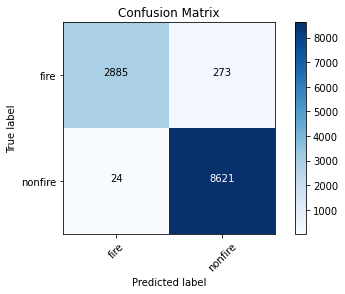

In [300]:
cm_plot_labels = ['fire','nonfire']
plot_confusion_matrix(cm ,cm_plot_labels, title='Confusion Matrix')